In [28]:
import requests
import pprint
import pandas as pd
import json
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import time
import csv
from concurrent.futures import ThreadPoolExecutor, as_completed


#pd.options.mode.copy_on_write = True

In [7]:
client_id = r'677185976af826b5950079c2'
client_secret = r'HofmdX0LBi0G7zKh0HL0qyMzY4m'

access_token = "67718565925e7647a10954ee|21b80554edfd8db57d765e10a768a09b"
refresh_token = "67718565925e7647a10954ee|95b745b97675000fa6f4e1435f6c3ced"

headers = {"Authorization": f"Bearer {access_token}"}

response = requests.get(f'https://api.netatmo.com/api/getpublicdata?lat_ne=61.99&lon_ne=8.99&lat_sw=60.0&lon_sw=5.0&required_data=rain&filter=true', headers=headers)
data = response.json()
#print(data)

In [30]:
# Grenser
nord_øst_lat = 63.0
nord_øst_lon = 13.0
sør_vest_lat = 58.0
sør_vest_lon = 5.0

# Rutestørrelse
breddegrad_steg = 0.25  # Endre til mindre for finere ruter
lengdegrad_steg = 0.5

# Liste for å lagre rutene
ruter = []


# Generer ruter
breddegrad = sør_vest_lat
while breddegrad < nord_øst_lat:
    lengdegrad = sør_vest_lon
    while lengdegrad < nord_øst_lon:
        rute = {
            "lat_ne": breddegrad + breddegrad_steg,
            "lon_ne": lengdegrad + lengdegrad_steg,
            "lat_sw": breddegrad,
            "lon_sw": lengdegrad,
        }
        ruter.append(rute)
        lengdegrad += lengdegrad_steg
    breddegrad += breddegrad_steg

# Vis resultatene
# for r in ruter:
#     print(f"Sør-vest: {r['sør_vest']}, Nord-øst: {r['nord_øst']}")

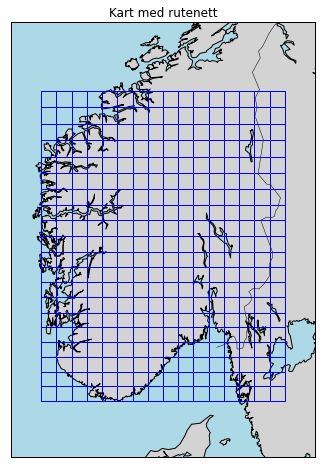

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))
m = Basemap(projection='merc',
            llcrnrlon=sør_vest_lon - 1, urcrnrlon=nord_øst_lon + 1,
            llcrnrlat=sør_vest_lat - 1, urcrnrlat=nord_øst_lat + 1,
            resolution='i', ax=ax)

# Tegn bakgrunnskart
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color="lightgray", lake_color="lightblue")
m.drawmapboundary(fill_color="lightblue")

# Tegn rutenett
for rute in ruter:
    sv = (rute["lat_sw"], rute["lon_sw"])
    ne = (rute["lat_ne"], rute["lon_ne"])
    x = [sv[1], ne[1], ne[1], sv[1], sv[1]]
    y = [sv[0], sv[0], ne[0], ne[0], sv[0]]
    x_proj, y_proj = m(x, y)

    ax.plot(x_proj, y_proj, color="blue", linewidth=1)

# Legg til tittel og vis kartet
plt.title("Kart med rutenett")
plt.show()

In [32]:
# Funksjon for å gjøre API-kall
def hent_data_for_rute(rute):
    lat_ne = rute["lat_ne"]
    lon_ne = rute["lon_ne"]
    lat_sw = rute["lat_sw"]
    lon_sw = rute["lon_sw"]

    url = f'https://api.netatmo.com/api/getpublicdata?lat_ne={lat_ne}&lon_ne={lon_ne}&lat_sw={lat_sw}&lon_sw={lon_sw}&required_data=rain&filter=true'

    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            data = response.json()
            return {"rute": rute, "data": data}
        else:
            return {"rute": rute, "error": f"Status {response.status_code}"}
    except Exception as e:
        return {"rute": rute, "error": str(e)}

# Lagre data til CSV
def lagre_til_csv(filnavn, resultater):
    with open(filnavn, mode='w', newline='', encoding='utf-8') as fil:
        writer = csv.writer(fil)
        # Skriv topptekst
        writer.writerow(["lat_sw", "lon_sw", "lat_ne", "lon_ne", "data", "error"])
        # Skriv resultater
        for resultat in resultater:
            rute = resultat["rute"]
            data = resultat.get("data")
            error = resultat.get("error", "")
            writer.writerow([
                rute["lat_sw"], rute["lon_sw"],
                rute["lat_ne"], rute["lon_ne"],
                data if data else "", error
            ])

# Parallell behandling av ruter
resultater = []
start_time = time.time()

with ThreadPoolExecutor(max_workers=10) as executor:  # Juster antall tråder etter behov
    fremtid_til_rute = {executor.submit(hent_data_for_rute, rute): rute for rute in ruter}

    for fremtid in as_completed(fremtid_til_rute):
        resultat = fremtid.result()
        resultater.append(resultat)

# Lagre til CSV-fil
lagre_til_csv("resultater.csv", resultater)

print(f"Ferdig! Resultater lagret til 'resultater.csv'. Kjøringstid: {time.time() - start_time:.2f} sekunder")

Ferdig! Resultater lagret til 'resultater.csv'. Kjøringstid: 53.62 sekunder


In [34]:
#print(data)

In [14]:
response = requests.get(f'https://api.netatmo.com/api/getmeasure?70:ee:50:29:63:9a', headers=headers)
data = response.json()

In [15]:
pprint.pp(data)

{'error': {'code': 10, 'message': 'Argument(s) is(are) missing'}}


In [30]:
df = pd.DataFrame(columns=['_id', 'longitude', 'latitude', 'rain_60min', 'rain_24h', 'rain_live'])
df

,_id,longitude,latitude,rain_60min,rain_24h,rain_live


In [31]:
_id = []
longitude = []
latitude = []
rain_60min = []
rain_24h = []
rain_live = []

# Loop through each record in the API response
for record in data['body']:
    _id.append(record['_id'])
    longitude.append(record['place']['location'][0])
    latitude.append(record['place']['location'][1])
    measures = list(record['measures'].values())[0]  # Assume we are interested in the first set of measures
    rain_60min.append(measures.get('rain_60min', None))
    rain_24h.append(measures.get('rain_24h', None))
    rain_live.append(measures.get('rain_live', None))

# Create the DataFrame using collected lists
df = pd.DataFrame({
    '_id': _id,
    'longitude': longitude,
    'latitude': latitude,
    'rain_60min': rain_60min,
    'rain_24h': rain_24h,
    'rain_live': rain_live
})

# Show the DataFrame
print(df)

                   _id  longitude   latitude rain_60min rain_24h rain_live
0    70:ee:50:39:f7:f4   7.038566  60.591824       None     None      None
1    70:ee:50:29:63:9a   7.998569  60.668120       None     None      None
2    70:ee:50:3c:07:a4   8.029679  60.726123       None     None      None
3    70:ee:50:20:e5:0c   8.051110  60.645878       None     None      None
4    70:ee:50:1e:2f:7a   8.282299  60.612103       None     None      None
..                 ...        ...        ...        ...      ...       ...
945  70:ee:50:6b:84:20   6.230185  60.413204       None     None      None
946  70:ee:50:58:dd:1e   6.234439  60.411933       None     None      None
947  70:ee:50:7b:0f:3e   6.622622  60.421448       None     None      None
948  70:ee:50:2b:60:e6   6.667145  60.404294       None     None      None
949  70:ee:50:3f:60:0e   6.702875  60.380077       None     None      None

[950 rows x 6 columns]


In [7]:
df_chain = (
    pd.DataFrame.from_dict(data)
    .assign(
    

SyntaxError: incomplete input (816627369.py, line 4)

In [8]:
df = pd.DataFrame.from_dict(data)
df_body = df['body'].apply(pd.Series)
df_place = df_body['place'].apply(pd.Series)
latlon = pd.DataFrame(df_place["location"].to_list(), columns=['longitude', 'latitude'])
df_measures = df_body['measures'].apply(pd.Series)
regn = df_measures.filter(like='05:00:00')
sammensatt = regn.astype(str).agg(', '.join, axis=1)
sammen = regn.fillna('').astype(str).sum(axis=1)
df_regnmengde = sammen.apply(lambda x: json.loads(x.replace("'", '"')))
df_regnmengde = df_regnmengde.apply(pd.Series)
df_data = pd.concat([df_body['_id'], latlon, df_regnmengde], axis=1)
df_data

,_id,longitude,latitude,rain_60min,rain_24h,rain_live,rain_timeutc
0,70:ee:50:7a:77:b8,5.347053,60.370827,0.000,0.000,0.0,1.715067e+09
1,70:ee:50:9c:f4:50,5.347644,60.370521,0.000,0.000,0.0,1.715067e+09
2,70:ee:50:af:9f:e4,5.349550,60.374054,0.000,0.000,0.0,1.715067e+09
3,70:ee:50:64:3a:5a,5.353428,60.366765,0.000,0.000,0.0,1.715068e+09
4,70:ee:50:90:cf:28,5.352444,60.370441,0.000,0.000,0.0,1.715067e+09
5,70:ee:50:2c:a8:42,5.352375,60.373732,0.000,0.000,0.0,1.715067e+09
6,70:ee:50:33:0d:dc,5.351659,60.375649,0.000,0.000,0.0,1.715068e+09
7,70:ee:50:36:c6:1e,5.364635,60.372002,0.000,0.000,0.0,1.715067e+09
8,70:ee:50:53:52:7c,5.376375,60.366256,0.101,0.101,0.0,1.715067e+09


In [9]:
df = pd.DataFrame.from_dict(data)
df_body = df['body'].apply(pd.Series)
df_body

,_id,place,mark,measures,modules,module_types
0,70:ee:50:7a:77:b8,"{'location': [5.34705340862274, 60.37082683152...",10,{'02:00:00:7a:b7:b6': {'res': {'1715067396': [...,"[02:00:00:7a:b7:b6, 05:00:00:08:f1:aa]","{'02:00:00:7a:b7:b6': 'NAModule1', '05:00:00:0..."
1,70:ee:50:9c:f4:50,"{'location': [5.347644, 60.370521], 'timezone'...",10,{'02:00:00:a2:6e:d8': {'res': {'1715067485': [...,"[02:00:00:a2:6e:d8, 05:00:00:0a:c2:02]","{'02:00:00:a2:6e:d8': 'NAModule1', '05:00:00:0..."
2,70:ee:50:af:9f:e4,"{'location': [5.34955, 60.374054], 'timezone':...",10,{'02:00:00:af:2b:e4': {'res': {'1715067481': [...,"[02:00:00:af:2b:e4, 05:00:00:0b:05:42]","{'02:00:00:af:2b:e4': 'NAModule1', '05:00:00:0..."
3,70:ee:50:64:3a:5a,"{'location': [5.3534277, 60.3667654], 'timezon...",10,{'02:00:00:64:40:76': {'res': {'1715067563': [...,"[02:00:00:64:40:76, 05:00:00:08:96:96, 06:00:0...","{'02:00:00:64:40:76': 'NAModule1', '05:00:00:0..."
4,70:ee:50:90:cf:28,"{'location': [5.352444, 60.370441], 'timezone'...",10,{'02:00:00:90:5f:a2': {'res': {'1715067406': [...,"[02:00:00:90:5f:a2, 05:00:00:09:af:d0]","{'02:00:00:90:5f:a2': 'NAModule1', '05:00:00:0..."
5,70:ee:50:2c:a8:42,"{'location': [5.352375, 60.373732], 'timezone'...",10,{'02:00:00:2c:ca:10': {'res': {'1715067502': [...,"[02:00:00:2c:ca:10, 05:00:00:06:6f:e0]","{'02:00:00:2c:ca:10': 'NAModule1', '05:00:00:0..."
6,70:ee:50:33:0d:dc,"{'location': [5.351659, 60.375649], 'timezone'...",10,{'02:00:00:33:3c:60': {'res': {'1715067638': [...,"[02:00:00:33:3c:60, 05:00:00:05:98:54]","{'02:00:00:33:3c:60': 'NAModule1', '05:00:00:0..."
7,70:ee:50:36:c6:1e,"{'location': [5.364635, 60.372002], 'timezone'...",10,{'02:00:00:36:ea:2c': {'res': {'1715067346': [...,"[02:00:00:36:ea:2c, 05:00:00:04:9a:2a, 06:00:0...","{'02:00:00:36:ea:2c': 'NAModule1', '05:00:00:0..."
8,70:ee:50:53:52:7c,"{'location': [5.376375, 60.366256], 'timezone'...",10,{'02:00:00:53:0c:d4': {'res': {'1715067264': [...,"[02:00:00:53:0c:d4, 05:00:00:0a:b2:d6]","{'02:00:00:53:0c:d4': 'NAModule1', '05:00:00:0..."


In [10]:
df_place = df_body['place'].apply(pd.Series)
latlon = pd.DataFrame(df_place["location"].to_list(), columns=['longitude', 'latitude'])
latlon

,longitude,latitude
0,5.347053,60.370827
1,5.347644,60.370521
2,5.349550,60.374054
3,5.353428,60.366765
4,5.352444,60.370441
5,5.352375,60.373732
6,5.351659,60.375649
7,5.364635,60.372002
8,5.376375,60.366256


In [11]:
df_measures = df_body['measures'].apply(pd.Series)
df_measures

,02:00:00:7a:b7:b6,70:ee:50:7a:77:b8,05:00:00:08:f1:aa,02:00:00:a2:6e:d8,70:ee:50:9c:f4:50,05:00:00:0a:c2:02,02:00:00:af:2b:e4,70:ee:50:af:9f:e4,05:00:00:0b:05:42,02:00:00:64:40:76,...,02:00:00:33:3c:60,70:ee:50:33:0d:dc,05:00:00:05:98:54,02:00:00:36:ea:2c,70:ee:50:36:c6:1e,05:00:00:04:9a:2a,06:00:00:03:2f:44,02:00:00:53:0c:d4,70:ee:50:53:52:7c,05:00:00:0a:b2:d6
0,"{'res': {'1715067396': [12.3, 82]}, 'type': ['...","{'res': {'1715067431': [1021.5]}, 'type': ['pr...","{'rain_60min': 0, 'rain_24h': 0, 'rain_live': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,"{'res': {'1715067485': [11.9, 79]}, 'type': ['...","{'res': {'1715067500': [1020.9]}, 'type': ['pr...","{'rain_60min': 0, 'rain_24h': 0, 'rain_live': ...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,"{'res': {'1715067481': [11.7, 81]}, 'type': ['...","{'res': {'1715067504': [1018.8]}, 'type': ['pr...","{'rain_60min': 0, 'rain_24h': 0, 'rain_live': ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'res': {'1715067563': [12.7, 79]}, 'type': ['...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'res': {'1715067638': [12.3, 85]}, 'type': ['...","{'res': {'1715067673': [1016.3]}, 'type': ['pr...","{'rain_60min': 0, 'rain_24h': 0, 'rain_live': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"{'res': {'1715067346': [11.4, 85]}, 'type': ['...","{'res': {'1715067392': [1016.8]}, 'type': ['pr...","{'rain_60min': 0, 'rain_24h': 0, 'rain_live': ...","{'wind_strength': 13, 'wind_angle': 263, 'gust...",NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'res': {'1715067264': [11.1, 88]}, 'type': ['...","{'res': {'1715067314': [1022.9]}, 'type': ['pr...","{'rain_60min': 0.101, 'rain_24h': 0.101, 'rain..."


In [12]:
regn = df_measures.filter(like='05:00:00')
regn.head()

,05:00:00:08:f1:aa,05:00:00:0a:c2:02,05:00:00:0b:05:42,05:00:00:08:96:96,05:00:00:09:af:d0,05:00:00:06:6f:e0,05:00:00:05:98:54,05:00:00:04:9a:2a,05:00:00:0a:b2:d6
0,"{'rain_60min': 0, 'rain_24h': 0, 'rain_live': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,"{'rain_60min': 0, 'rain_24h': 0, 'rain_live': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,"{'rain_60min': 0, 'rain_24h': 0, 'rain_live': ...",NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,"{'rain_60min': 0, 'rain_24h': 0, 'rain_live': ...",NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,"{'rain_60min': 0, 'rain_24h': 0, 'rain_live': ...",NaN,NaN,NaN,NaN


In [13]:
sammensatt = regn.astype(str).agg(', '.join, axis=1)
sammensatt

0    {'rain_60min': 0, 'rain_24h': 0, 'rain_live': ...
1    nan, {'rain_60min': 0, 'rain_24h': 0, 'rain_li...
2    nan, nan, {'rain_60min': 0, 'rain_24h': 0, 'ra...
3    nan, nan, nan, {'rain_60min': 0, 'rain_24h': 0...
4    nan, nan, nan, nan, {'rain_60min': 0, 'rain_24...
5    nan, nan, nan, nan, nan, {'rain_60min': 0, 'ra...
6    nan, nan, nan, nan, nan, nan, {'rain_60min': 0...
7    nan, nan, nan, nan, nan, nan, nan, {'rain_60mi...
8    nan, nan, nan, nan, nan, nan, nan, nan, {'rain...
dtype: object

In [14]:
sammen = regn.fillna('').astype(str).sum(axis=1)
sammen

0    {'rain_60min': 0, 'rain_24h': 0, 'rain_live': ...
1    {'rain_60min': 0, 'rain_24h': 0, 'rain_live': ...
2    {'rain_60min': 0, 'rain_24h': 0, 'rain_live': ...
3    {'rain_60min': 0, 'rain_24h': 0, 'rain_live': ...
4    {'rain_60min': 0, 'rain_24h': 0, 'rain_live': ...
5    {'rain_60min': 0, 'rain_24h': 0, 'rain_live': ...
6    {'rain_60min': 0, 'rain_24h': 0, 'rain_live': ...
7    {'rain_60min': 0, 'rain_24h': 0, 'rain_live': ...
8    {'rain_60min': 0.101, 'rain_24h': 0.101, 'rain...
dtype: object

In [15]:
print(sammen[0])

{'rain_60min': 0, 'rain_24h': 0, 'rain_live': 0, 'rain_timeutc': 1715067422}


In [16]:
kart = pd.concat([df_place['location'], sammen], axis=1)
kart.rename(columns={0: 'rain'}, inplace=True)
kart

,location,rain
0,"[5.34705340862274, 60.3708268315293]","{'rain_60min': 0, 'rain_24h': 0, 'rain_live': ..."
1,"[5.347644, 60.370521]","{'rain_60min': 0, 'rain_24h': 0, 'rain_live': ..."
2,"[5.34955, 60.374054]","{'rain_60min': 0, 'rain_24h': 0, 'rain_live': ..."
3,"[5.3534277, 60.3667654]","{'rain_60min': 0, 'rain_24h': 0, 'rain_live': ..."
4,"[5.352444, 60.370441]","{'rain_60min': 0, 'rain_24h': 0, 'rain_live': ..."
5,"[5.352375, 60.373732]","{'rain_60min': 0, 'rain_24h': 0, 'rain_live': ..."
6,"[5.351659, 60.375649]","{'rain_60min': 0, 'rain_24h': 0, 'rain_live': ..."
7,"[5.364635, 60.372002]","{'rain_60min': 0, 'rain_24h': 0, 'rain_live': ..."
8,"[5.376375, 60.366256]","{'rain_60min': 0.101, 'rain_24h': 0.101, 'rain..."


In [17]:
df_regnmengde = sammen.apply(lambda x: json.loads(x.replace("'", '"')))
df_regnmengde = df_regnmengde.apply(pd.Series)
df_regnmengde

,rain_60min,rain_24h,rain_live,rain_timeutc
0,0.000,0.000,0.0,1.715067e+09
1,0.000,0.000,0.0,1.715067e+09
2,0.000,0.000,0.0,1.715067e+09
3,0.000,0.000,0.0,1.715068e+09
4,0.000,0.000,0.0,1.715067e+09
5,0.000,0.000,0.0,1.715067e+09
6,0.000,0.000,0.0,1.715068e+09
7,0.000,0.000,0.0,1.715067e+09
8,0.101,0.101,0.0,1.715067e+09


In [18]:
df_data = pd.concat([df_body['_id'], latlon, df_regnmengde], axis=1)
df_data

,_id,longitude,latitude,rain_60min,rain_24h,rain_live,rain_timeutc
0,70:ee:50:7a:77:b8,5.347053,60.370827,0.000,0.000,0.0,1.715067e+09
1,70:ee:50:9c:f4:50,5.347644,60.370521,0.000,0.000,0.0,1.715067e+09
2,70:ee:50:af:9f:e4,5.349550,60.374054,0.000,0.000,0.0,1.715067e+09
3,70:ee:50:64:3a:5a,5.353428,60.366765,0.000,0.000,0.0,1.715068e+09
4,70:ee:50:90:cf:28,5.352444,60.370441,0.000,0.000,0.0,1.715067e+09
5,70:ee:50:2c:a8:42,5.352375,60.373732,0.000,0.000,0.0,1.715067e+09
6,70:ee:50:33:0d:dc,5.351659,60.375649,0.000,0.000,0.0,1.715068e+09
7,70:ee:50:36:c6:1e,5.364635,60.372002,0.000,0.000,0.0,1.715067e+09
8,70:ee:50:53:52:7c,5.376375,60.366256,0.101,0.101,0.0,1.715067e+09


In [19]:
print(kart['rain'].iloc[0])

{'rain_60min': 0, 'rain_24h': 0, 'rain_live': 0, 'rain_timeutc': 1715067422}


In [20]:
verdi = json.loads(kart['rain'].iloc[0].replace("\'", "\""))

In [21]:
print(verdi['rain_60min'])

0


In [22]:
import ast

In [23]:
def parse_json_string(json_str):
    json_dict = ast.literal_eval(json_str)  # Safely parse the string to a dictionary
    return pd.Series(json_dict)

In [24]:
kart['rain'] = kart['rain'].str.replace("\'", "\"")
kart['rain'] = kart['rain'].apply(parse_json_string)
kart

ValueError: Columns must be same length as key

In [25]:
print(kart['rain'].iloc[0])

{"rain_60min": 0, "rain_24h": 0, "rain_live": 0, "rain_timeutc": 1715067422}


In [26]:
tall = json.loads(kart['rain'].iloc[0])
print(tall["rain_24h"])

0


In [27]:
df = pd.DataFrame({
    'weather': [
        "{'rain_60min': 0, 'rain_24h': 6.666, 'rain_live': 0, 'rain_timeutc': 1693335972}",
        "{'rain_60min': 1, 'rain_24h': 2.22, 'rain_live': 1, 'rain_timeutc': 1693355972}",
        "{'rain_60min': 2, 'rain_24h': 5.55, 'rain_live': 2, 'rain_timeutc': 1693385972}"
    ]
})

# Convert the 'weather' string to a dictionary
df['weather_dict'] = df['weather'].apply(lambda x: json.loads(x.replace("'", '"')))

# Create new columns based on the dictionary keys
df[['rain_60min', 'rain_24h', 'rain_live', 'rain_timeutc']] = df['weather_dict'].apply(pd.Series)

# Drop the original and intermediate columns
df.drop(['weather', 'weather_dict'], axis=1, inplace=True)

print(df)

   rain_60min  rain_24h  rain_live  rain_timeutc
0         0.0     6.666        0.0  1.693336e+09
1         1.0     2.220        1.0  1.693356e+09
2         2.0     5.550        2.0  1.693386e+09
